# The ROC evaluation of QC experiments 

In [2]:
import sys
import h5py
import numpy as np
import pandas as pd
from glob import glob
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/QC_OBS/utils/')
sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')

from namelist import *

import QC_utils as qu
import data_utils as du
import graph_utils as gu

In [5]:
#https://www.rapidtables.com/web/color/RGB_Color.html

REDs = []
REDs.append(gu.xcolor('light salmon'))
REDs.append(gu.xcolor('light coral'))
REDs.append(gu.xcolor('indian red'))
REDs.append(gu.xcolor('dark red'))

BLUEs = []
BLUEs.append(gu.xcolor('light blue'))
BLUEs.append(gu.xcolor('sky blue'))
BLUEs.append(gu.xcolor('royal blue'))
BLUEs.append(gu.xcolor('midnight blue'))


JET = []
JET.append(gu.xcolor('indian red'))
JET.append(gu.xcolor('gold'))
JET.append(gu.xcolor('dark sea green'))
JET.append(gu.xcolor('deep sky blue'))
JET.append(gu.xcolor('royal blue'))
JET = JET[::-1]

In [6]:
# ===== Macro ===== #
#ens = 6 # < ----------------- !!! number of classifiers !!!
#freq = 'LOW_'
save_dir = '/glade/work/ksha/data/Keras/QC_publish/'
eval_dir = '/glade/work/ksha/data/evaluation/'
data_dir0 = HOLD_dir+freq+'CAPA_TRAIN_pack.hdf'
data_dir1 = HOLD_dir+freq+'CAPA_VALID_pack.hdf'
data_dir2 = HOLD_dir+freq+'CAPA_TEST_pack.hdf'
fig_dir = '/glade/u/home/ksha/figures/'

# Loading models and data

In [8]:
# # TRAIN
# hdf_io = h5py.File(data_dir0, 'r')
# grid_input0 = hdf_io['capa_input'][...]
# stn_input0  = hdf_io['stn_input'][...]
# cate_out0   = hdf_io['cate_out'][...]
# #capa_ref0   = hdf_io['capa_ref'][...]
# stn_code0   = np.array(du.str_decode(hdf_io['xstn_code'][...]))
# hdf_io.close()
# # VALID
# hdf_io = h5py.File(data_dir1, 'r')
# grid_input1 = hdf_io['capa_input'][...]
# stn_input1  = hdf_io['stn_input'][...]
# cate_out1   = hdf_io['cate_out'][...]
# #capa_ref1   = hdf_io['capa_ref'][...]
# stn_code1   = np.array(du.str_decode(hdf_io['xstn_code'][...]))
# hdf_io.close()
# # TEST
# hdf_io = h5py.File(data_dir2, 'r')
# grid_input2 = hdf_io['capa_input'][...]
# stn_input2  = hdf_io['stn_input'][...]
# cate_out2   = hdf_io['cate_out'][...]
# #capa_ref2   = hdf_io['capa_ref'][...]
# stn_code2   = np.array(du.str_decode(hdf_io['xstn_code'][...]))
# hdf_io.close()

In [9]:
# C = ['r', 'g', 'b', 'y', 'k', 'gray']

# fig = plt.figure(figsize=(13, 4))
# ax = fig.gca()
# ax = gu.ax_decorate(ax, True, True)
# for i in range(ens):
#     key = freq+'QC_CNN'+str(i)
#     record = np.load(save_dir+key+'_records.hdf.npy', allow_pickle=True)
#     val_loss = record[()]['val_loss']
#     ind = np.argmin(val_loss)
#     ax.plot(record[()]['loss'][:ind+1], lw=3, ls='--', c=C[i], label='Classifier {}, train loss'.format(i))
#     ax.plot(record[()]['val_loss'][:ind+1], lw=3, ls='-', c= C[i], label='Classifier {}, valid loss'.format(i))
# LG = gu.lg_decorate(ax, loc=(1, 1))

# ax.set_ylabel('Cross-entropy Loss', fontsize=14)
# ax.set_xlabel('Epoches', fontsize=14)

# ROC and AUC bootstrapping

In [80]:
from scipy import interp
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils import resample

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes, mark_inset

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def ROC_range(FP_boost, TP_boost, N):
    FP_base = np.linspace(0, 1, N)
    TP_base = np.empty((TP_boost.shape[0], N))
    for i in range(TP_boost.shape[0]):
        TP_base[i, :] = interp(FP_base, FP_boost[i, :], TP_boost[i, :])
    TP_std = np.nanstd(TP_base, axis=0)
    TP_mean = np.nanmean(TP_base, axis=0)
    TP_upper = np.minimum(TP_mean + 3*TP_std, 1)
    TP_lower = np.maximum(TP_mean - 3*TP_std, 0)
    return FP_base, TP_mean, TP_lower, TP_upper

In [13]:
data_temp = np.load(eval_dir+'EVAL_QC_members.npy', allow_pickle=True)
cate_train = data_temp[()]['cate_train']
cate_valid = data_temp[()]['cate_valid']
cate_test = data_temp[()]['cate_test']
REPORT = data_temp[()]['REPORT']
AUC_elev_eval = data_temp[()]['AUC']
TP = data_temp[()]['TP']
FP = data_temp[()]['FP']
names = list(REPORT.keys())

data_temp = np.load(eval_dir+'EVAL_QC_noelev_members.npy', allow_pickle=True)
AUC_noelev_eval = data_temp[()]['AUC']

data_temp = np.load(eval_dir+'EVAL_QC_MLP_members.npy', allow_pickle=True)
AUC_mlp_eval = data_temp[()]['AUC']

In [14]:
data_temp = np.load(eval_dir+'EVAL_QC_members.npy', allow_pickle=True)

In [15]:
with h5py.File(HOLD_dir+freq+'CAPA_TEST_pack.hdf', 'r') as h5io:
    cate_out = h5io['cate_out'][...]

In [87]:
with h5py.File(eval_dir+'EVAL_QC_MLP_boost.hdf', 'r') as h5io:
    cate_boost_mlp = h5io['cate_boost'][...]
    FP_mlp = h5io['FP_boost'][...]
    TP_mlp = h5io['TP_boost'][...]
    AUC_mlp = h5io['AUC_boost'][...]

with h5py.File(eval_dir+'EVAL_QC_noelev_boost.hdf', 'r') as h5io:
    FP_noelev = h5io['FP_boost'][...]
    TP_noelev = h5io['TP_boost'][...]
    AUC_noelev = h5io['AUC_boost'][...]

with h5py.File(eval_dir+'EVAL_QC_boost.hdf', 'r') as h5io:
    cate_p = h5io['cate_p'][...]
    cate_boost = h5io['cate_boost'][...]
    FP_elev = h5io['FP_boost'][...]
    TP_elev = h5io['TP_boost'][...]
    AUC_elev = h5io['AUC_boost'][...]
    
temp_data = np.load(eval_dir+'ENS_boost.npy', allow_pickle=True)
TP_ens = temp_data[()]['TP']
FP_ens = temp_data[()]['FP']
AUC_ens = temp_data[()]['AUC']

**Extra decision tree results**

In [103]:
tree_baseline = '/glade/work/ksha/data/evaluation/EVAL_QC_TREE_members.npy'
data_temp = np.load(tree_baseline, allow_pickle=True)
cate_tree = data_temp[()]['cate_test']
auc_tree = data_temp[()]['AUC']

AUC_tree = np.empty(AUC_mlp.shape)
FP_tree = np.empty(FP_mlp.shape); FP_tree[...] = np.nan
TP_tree = np.empty(TP_mlp.shape); TP_tree[...] = np.nan

inds = np.arange(len(cate_out), dtype=np.int)

for i in range(5):
    for j in range(200):

        inds_ = resample(inds)
        fpr_, tpr_, _ = roc_curve(cate_out[inds_], cate_tree[inds_, i])
        AUC_tree[i, j] = auc(fpr_, tpr_)
        L = len(fpr_)
        FP_tree[i, j, :L] = fpr_
        TP_tree[i, j, :L] = tpr_

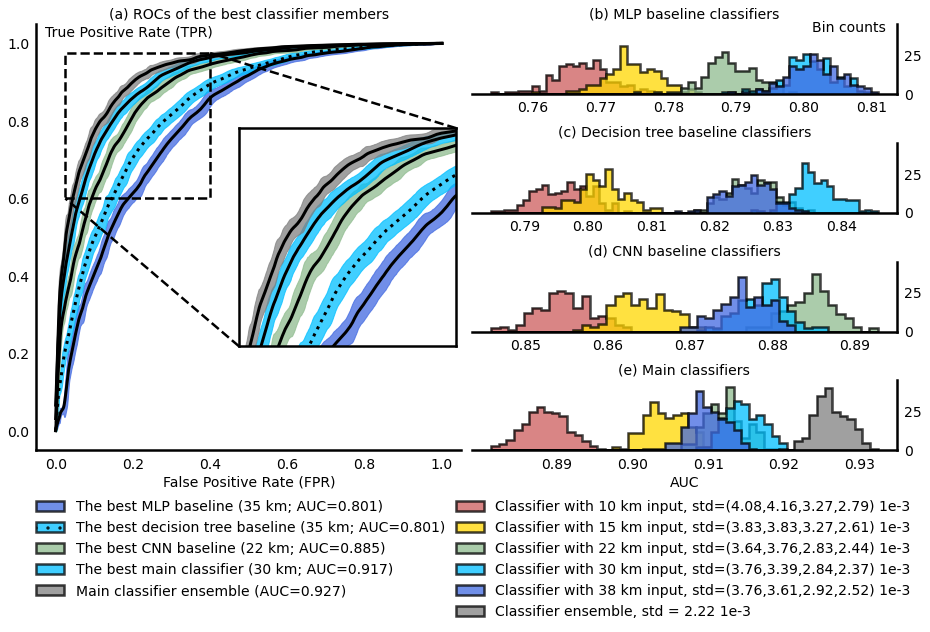

In [133]:
labels = ['10 km', '15 km', '22 km', '30 km', '38 km']

#BINS = np.linspace(np.min(AUC_mlp), np.max(AUC_elev), 100)
BINS1 = np.arange(np.min(AUC_mlp), np.max(AUC_mlp)+0.001, 0.001)
BINS2 = np.arange(np.min(AUC_tree), np.max(AUC_tree)+0.001, 0.001)
BINS3 = np.arange(np.min(AUC_noelev), np.max(AUC_noelev)+0.001, 0.001)
BINS4 = np.arange(np.min(AUC_elev), np.max(AUC_ens)+0.001, 0.001)

fig = plt.figure(figsize=(13, 7))
ax1 = plt.subplot2grid((4, 2), (0, 0), rowspan=4)
ax2 = plt.subplot2grid((4, 2), (0, 1))
ax3 = plt.subplot2grid((4, 2), (1, 1))
ax4 = plt.subplot2grid((4, 2), (2, 1))
ax5 = plt.subplot2grid((4, 2), (3, 1))

AX_hist = [ax2, ax3, ax4, ax5]

ax1 = gu.ax_decorate(ax1, True, True)
ax1.spines["bottom"].set_visible(True)
ax1.grid(False)

for ax in AX_hist:
    ax = gu.ax_decorate(ax, True, True)
    ax.grid(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)
    ax.tick_params(axis="both", which="both", 
                   bottom=False, top=False, labelbottom=True, 
                   left=False, labelleft=False, right=False, labelright=True)
    ax.set_ylim([0, 45])

ax2.text(0.975, 0.95, 'Bin counts', ha='right', va='center', transform=ax2.transAxes, fontsize=14)
ax3.yaxis.set_label_position("right")
ax5.set_xticks([0.89, 0.90, 0.91, 0.92, 0.93])
ax5.set_xlabel('AUC', fontsize=14)

ax1.set_xlabel('False Positive Rate (FPR)', fontsize=14)
ax1.text(0.02, 0.98, 'True Positive Rate (TPR)', ha='left', va='center', transform=ax1.transAxes, fontsize=14)
ax1_sub = zoomed_inset_axes(ax1, 1.5, loc=5)
ax1_sub = gu.ax_decorate(ax1_sub, False, False)
[j.set_linewidth(2.5) for j in ax1_sub.spines.values()]
ax1_sub.spines["left"].set_visible(True)
ax1_sub.spines["right"].set_visible(True)
ax1_sub.spines["bottom"].set_visible(True)
ax1_sub.spines["top"].set_visible(True)
ax1_sub.set_xlim([0.025, 0.4])
ax1_sub.set_ylim([0.6, 0.975])
ax1_sub.grid(False)

ind = 1
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_mlp[ind, ...], TP_mlp[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[0], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[0], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

ind = 1
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_tree[ind, ...], TP_tree[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, ls=':', color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, ls=':', color='k')

ind = 2
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_noelev[ind, ...], TP_noelev[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[2], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[2], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

ind = 0
FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_elev[ind, ...], TP_elev[ind, ...], 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color=JET[1], alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

FP_base, TP_base, TP_lower, TP_upper = ROC_range(FP_ens, TP_ens, 1000)
ax1.fill_between(FP_base, TP_lower, TP_upper, color='0.5', alpha=0.75)
ax1.plot(FP_base, TP_base, lw=3, color='k')
ax1_sub.fill_between(FP_base, TP_lower, TP_upper, color='0.5', alpha=0.75)
ax1_sub.plot(FP_base, TP_base, lw=3, color='k')

mark_inset(ax1, ax1_sub, loc1=1, loc2=3, fc='none', ec='k', lw=2.5, ls='--')
legend_patch = []; 
for i in range(ens):
    std_auc = []
    # MLP baseline
    ax2.hist(AUC_mlp[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS1)
    ax2.hist(AUC_mlp[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS1)
    std_auc.append(np.around(1e3*np.std(AUC_mlp[ens-1-i, :]), 2))
    # TREE baseline
    ax3.hist(AUC_tree[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS2)
    ax3.hist(AUC_tree[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS2)
    std_auc.append(np.around(1e3*np.std(AUC_tree[ens-1-i, :]), 2))
    
    # CNN baseline
    ax4.hist(AUC_noelev[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS3)
    ax4.hist(AUC_noelev[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS3)
    std_auc.append(np.around(1e3*np.std(AUC_noelev[ens-1-i, :]), 2))
    # CNN ours
    ax5.hist(AUC_elev[ens-1-i, :], alpha=0.75, histtype='stepfilled', facecolor=JET[ens-1-i], bins=BINS4)
    ax5.hist(AUC_elev[ens-1-i, :], alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS4)
    std_auc.append(np.around(1e3*np.std(AUC_elev[ens-1-i, :]), 2))
    
    legend_patch.append(mpatches.Patch(facecolor=JET[ens-1-i], edgecolor='k', linewidth=2.5, alpha=0.75, 
                                       label='Classifier with {} input, std=({},{},{},{}) 1e-3'.format(
                                           labels[i], std_auc[0], std_auc[1], std_auc[2], std_auc[3])))
# (extra) classifier ensemble
ax5.hist(AUC_ens, alpha=0.75, histtype='stepfilled', facecolor='0.5', bins=BINS4)    
ax5.hist(AUC_ens, alpha=0.75, histtype='step', linewidth=2.5, edgecolor='k', bins=BINS4)
std_ens = np.around(1e3*np.std(AUC_ens), 2)

legend_patch.append(mpatches.Patch(facecolor='0.5', edgecolor='k', linewidth=2.5, alpha=0.75, 
                                   label='Classifier ensemble, std = {} 1e-3'.format(std_ens)))

legend_roc = [] 
legend_roc.append(mpatches.Patch(facecolor=JET[0], edgecolor='k', linewidth=2.5, alpha=0.75, 
                                 label='The best MLP baseline (35 km; AUC={0:0.3f})'.format(AUC_mlp_eval['ENS0'])))
legend_roc.append(mpatches.Patch(facecolor=JET[1], hatch='.', edgecolor='k', linewidth=2.5, alpha=0.75, 
                                 label='The best decision tree baseline (35 km; AUC={0:0.3f})'.format(AUC_mlp_eval['ENS0'])))
legend_roc.append(mpatches.Patch(facecolor=JET[2], edgecolor='k', linewidth=2.5, alpha=0.75, 
                                 label='The best CNN baseline (22 km; AUC={0:0.3f})'.format(AUC_noelev_eval['ENS2'])))
legend_roc.append(mpatches.Patch(facecolor=JET[1], edgecolor='k', linewidth=2.5, alpha=0.75, 
                                 label='The best main classifier (30 km; AUC={0:0.3f})'.format(AUC_elev_eval['ENS1'])))
legend_roc.append(mpatches.Patch(facecolor='0.5', edgecolor='k', linewidth=2.5, alpha=0.75, 
                                 label='Main classifier ensemble (AUC={0:0.3f})'.format(AUC_elev_eval['ENS'])))

ax_lg = fig.add_axes([0.0675, -0.075, 0.425, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_roc, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax_lg = fig.add_axes([0.19, -0.075, 0.8, 0.1])
ax_lg.set_axis_off()
LG = ax_lg.legend(handles=legend_patch, bbox_to_anchor=(1, 1), ncol=1, prop={'size':14});
LG.get_frame().set_facecolor('white')
LG.get_frame().set_edgecolor('k')
LG.get_frame().set_linewidth(0)

ax1.set_title('(a) ROCs of the best classifier members', fontsize=14)
ax2.set_title('(b) MLP baseline classifiers', fontsize=14)
ax3.set_title('(c) Decision tree baseline classifiers', fontsize=14)
ax4.set_title('(d) CNN baseline classifiers', fontsize=14)
ax5.set_title('(e) Main classifiers', fontsize=14)
plt.tight_layout()

# fig.savefig(fig_dir+'QC_ROC_Boostrap.png', dpi=250, orientation='portrait', 
#             papertype='a4', format='png', bbox_inches='tight', pad_inches=0.1)

# Bootstrapping tests (old)

In [116]:
from sklearn.utils import resample

In [117]:
inds = list(range(L2))

In [118]:
hdf_io = h5py.File('/glade/u/home/ksha/data/evaluation/EVAL_QC_boost.hdf', 'r')
AUC_boost = hdf_io['AUC_boost'][...]
TP_boost = hdf_io['TP_boost'][...]
FP_boost = hdf_io['FP_boost'][...]
hdf_io.close()

In [119]:
AUC_boost.shape

(6, 200)

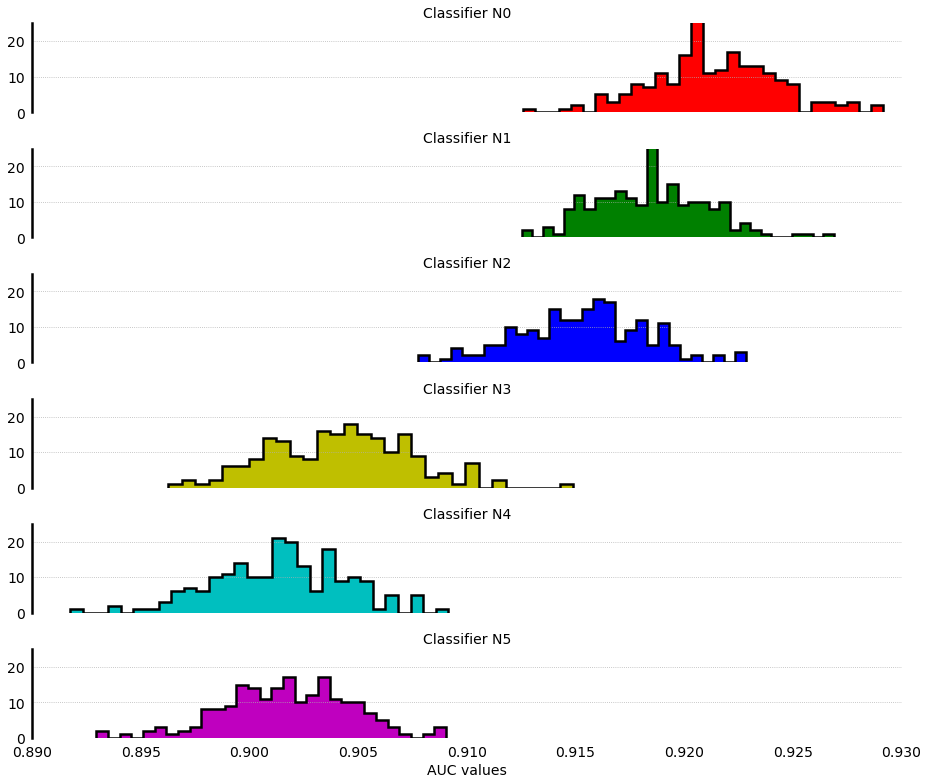

In [120]:
fig = plt.figure(figsize=(13, 11))
ax1 = plt.subplot(6, 1, 1)
ax2 = plt.subplot(6, 1, 2)
ax3 = plt.subplot(6, 1, 3)
ax4 = plt.subplot(6, 1, 4)
ax5 = plt.subplot(6, 1, 5)
ax6 = plt.subplot(6, 1, 6)
AX = [ax1, ax2, ax3, ax4, ax5, ax6]
C = ['r', 'g', 'b', 'y', 'c', 'm']
for i in range(ens):
    ax = AX[i]
    ax.set_xlim([0.89, 0.93])
    ax.set_ylim([0, 25])
    if i!=5:
        ax = gu.ax_decorate(ax, True, False)
    ax.hist(AUC_boost[i, :], 30, histtype='step', color='k', linewidth=2.5, zorder=4)
    ax.hist(AUC_boost[i, :], 30, histtype='stepfilled', color=C[i], label='Classifier N{}'.format(i))
    ax.set_title('Classifier N{}'.format(i), fontsize=14)
ax6 = gu.ax_decorate(ax, True, True)
ax6.set_xlabel('AUC values', fontsize=14)
#ax.set_ylabel('counts', fontsize=14)
plt.tight_layout()